Enter stock ticker (e.g., AAPL):  AAPL
Enter start date for historical data (YYYY-MM-DD):  2021-01-01
Enter number of days to forecast (e.g., 252):  252
Enter number of Monte Carlo simulations (e.g., 1000):  1000
Risk-free rate (e.g., 0.04 for 4%):  0.04
Expected market return (e.g., 0.08):  0.08


[*********************100%***********************]  1 of 1 completed


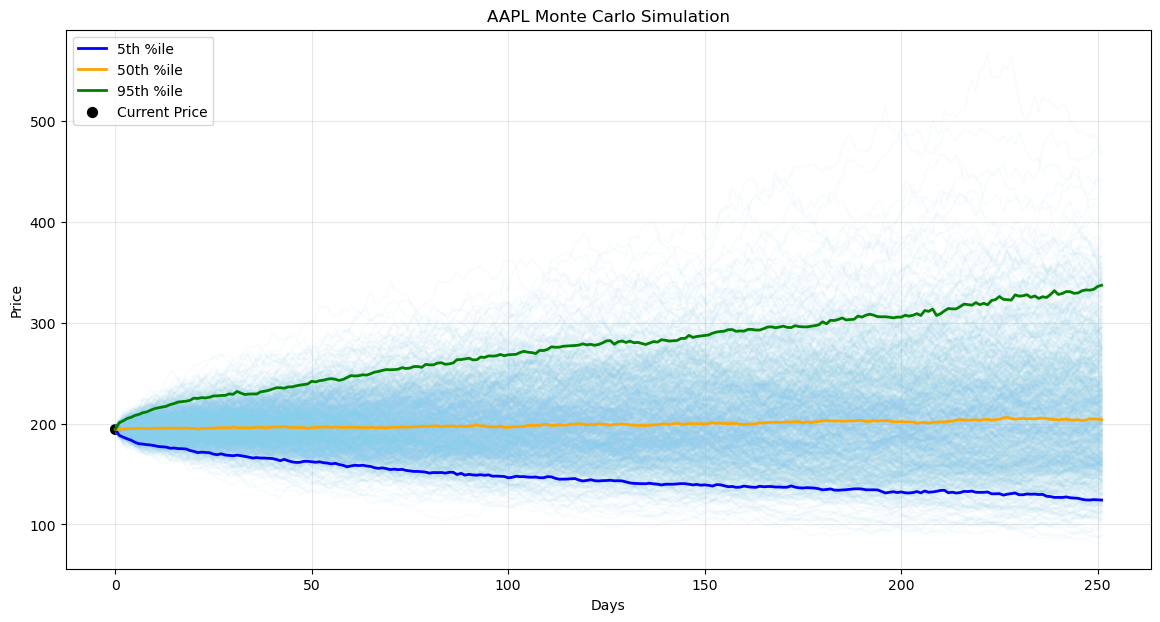

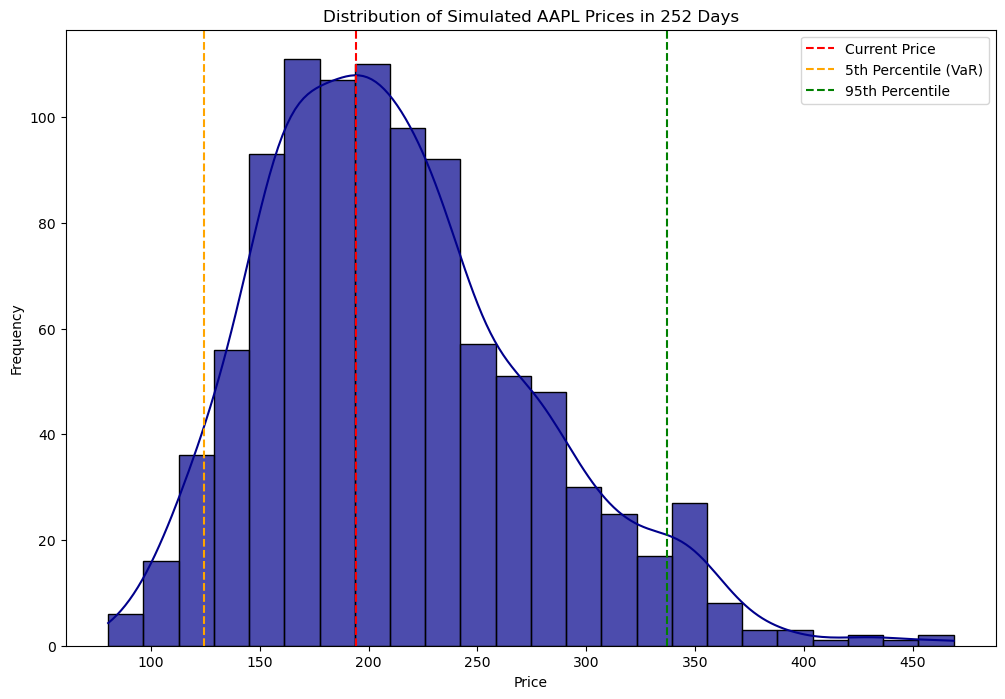

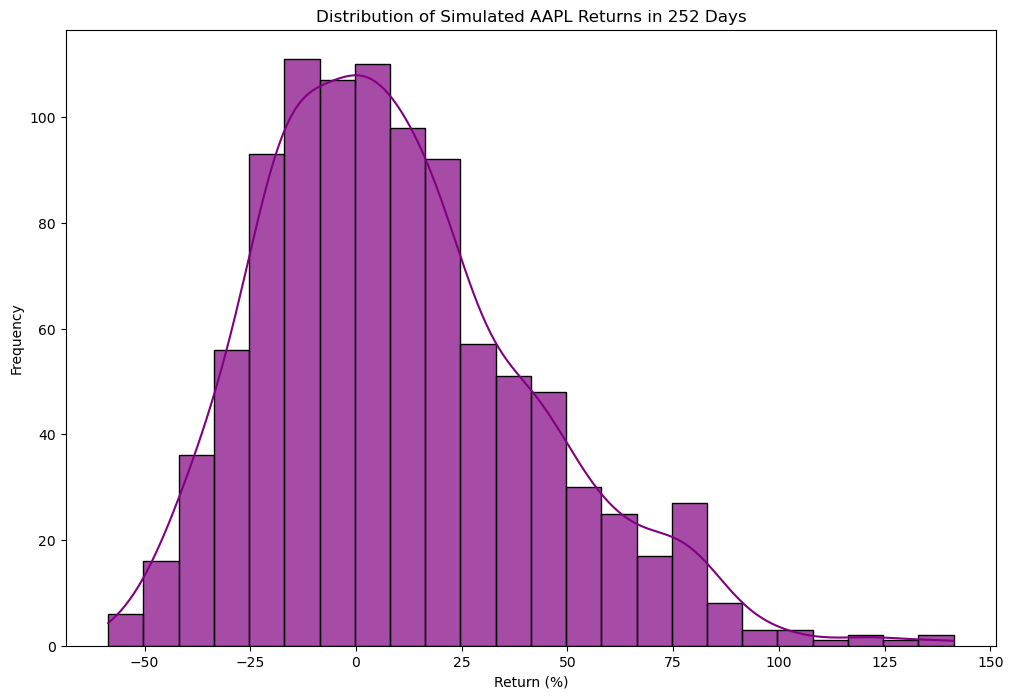

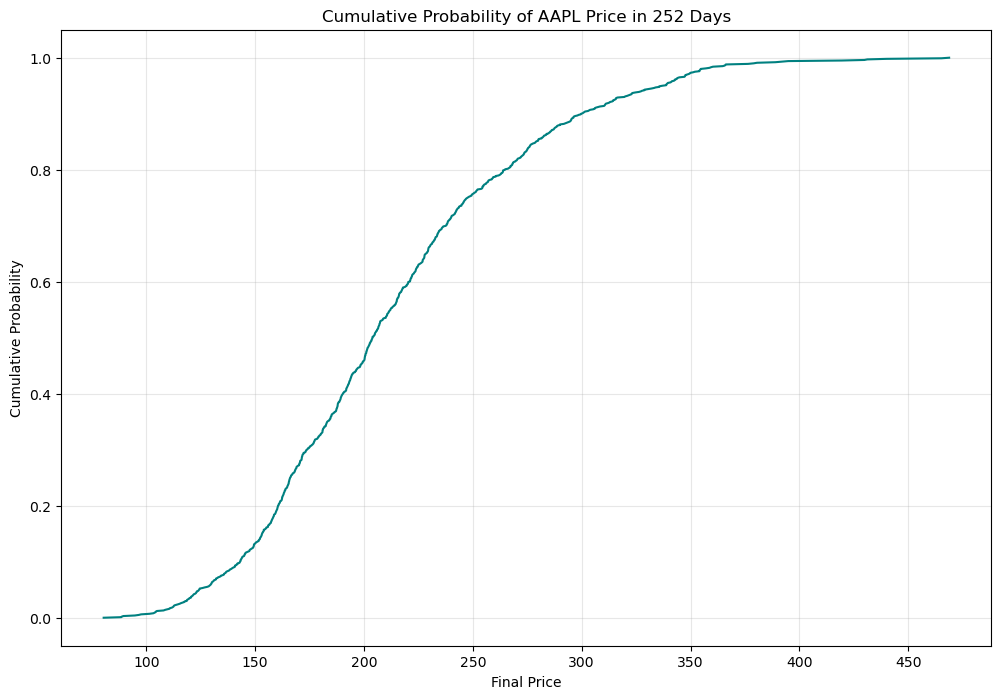

[*********************100%***********************]  1 of 1 completed


--- Simulation Results for AAPL ---
Expected price in 252 days: $213.45
95% confidence interval: $115.35 - $352.05
5% Value at Risk (VaR): $124.22
5% Conditional Value at Risk (CVaR): $112.07
Probability of loss (ending below current price): 43.20%
Probability of gain (ending above current price): 56.80%
Mean Sharpe Ratio (simulated): 0.18
Simulated 1-year return: 9.87%
CAPM 1-year expected return: 9.03%
Beta (vs GSPC): 1.26

--- Security Comparison ---
1. Compare with market index (S&P 500)
2. Compare with another security


Choose an option (1/2):  2
Enter comparison ticker (e.g., MSFT):  META


[*********************100%***********************]  1 of 1 completed



--- Comparison Results: AAPL vs META ---
Historical Price Correlation: 0.5078
Simulated Future R²: 0.2625


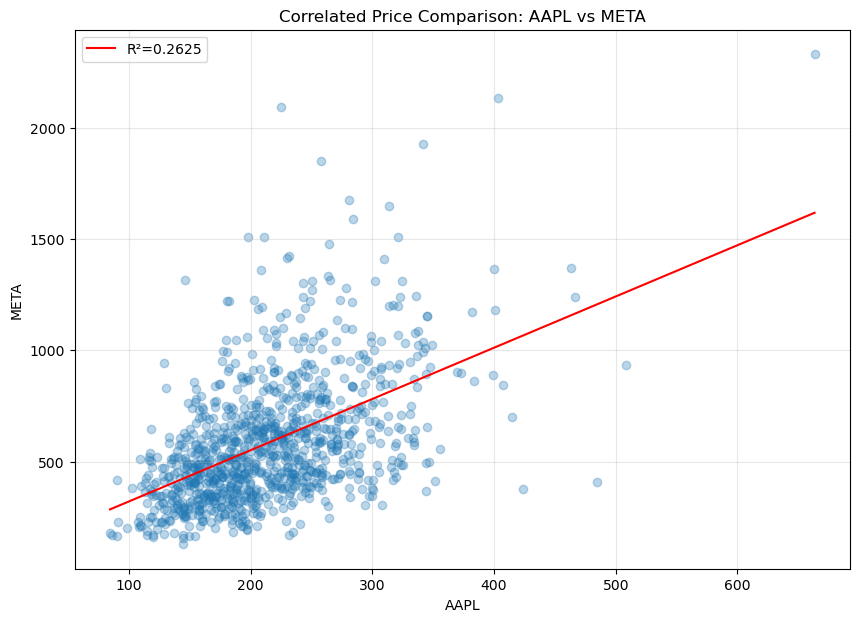


Add another comparison? (y/n):  N


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# --- User Input for Parameters ---
ticker = input("Enter stock ticker (e.g., AAPL): ").upper()
start_date = input("Enter start date for historical data (YYYY-MM-DD): ")
forecast_days = int(input("Enter number of days to forecast (e.g., 252): "))
n_simulations = int(input("Enter number of Monte Carlo simulations (e.g., 1000): "))
rf = float(input("Risk-free rate (e.g., 0.04 for 4%): "))
market_return = float(input("Expected market return (e.g., 0.08): "))

# --- Fetch Historical Data ---
data = yf.download(ticker, start=start_date)
close_prices = data['Close']

# --- Calculate Log Returns ---
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()
mu = log_returns.mean().item()
sigma = log_returns.std().item()

# --- Monte Carlo Simulation ---
last_price = close_prices.iloc[-1].item()
simulations = np.zeros((forecast_days, n_simulations))

for sim in range(n_simulations):
    price_series = np.zeros(forecast_days)
    price_series[0] = last_price
    for day in range(1, forecast_days):
        drift = mu - (0.5 * sigma ** 2)
        shock = sigma * np.random.normal()
        price_series[day] = price_series[day-1] * np.exp(drift + shock)
    simulations[:, sim] = price_series

# --- Risk Metrics ---
final_prices = simulations[-1, :]
returns = (final_prices - last_price) / last_price * 100  # Percentage returns
expected_price = np.mean(final_prices)
confidence_low = np.percentile(final_prices, 2.5)
confidence_high = np.percentile(final_prices, 97.5)
VaR_5 = np.percentile(final_prices, 5)
CVaR_5 = final_prices[final_prices <= VaR_5].mean()
prob_loss = np.mean(final_prices < last_price)
prob_gain = np.mean(final_prices > last_price)

# Calculate Sharpe Ratio for each simulation
annual_return = (final_prices / last_price) - 1
sharpe_ratio = (annual_return - rf) / (np.std(annual_return))
mean_sharpe = np.mean(sharpe_ratio)

# --- Visualization: Simulated Price Paths ---
plt.figure(figsize=(14, 7))
plt.plot(simulations, color='skyblue', alpha=0.05)
for p, c in zip([5, 50, 95], ['blue', 'orange', 'green']):
    plt.plot(np.percentile(simulations, p, axis=1), color=c, linewidth=2, label=f'{p}th %ile')
plt.scatter(0, last_price, color='black', s=50, label='Current Price')
plt.title(f"{ticker} Monte Carlo Simulation")
plt.xlabel("Days"), plt.ylabel("Price")
plt.legend(), plt.grid(alpha=0.3)
plt.show()

# --- Visualization: Price Distribution ---
plt.figure(figsize=(12, 8))
sns.histplot(final_prices, kde=True, color='darkblue', alpha=0.7)
plt.axvline(x=last_price, color='red', linestyle='--', label='Current Price')
plt.axvline(x=VaR_5, color='orange', linestyle='--', label='5th Percentile (VaR)')
plt.axvline(x=np.percentile(final_prices, 95), color='green', linestyle='--', label='95th Percentile')
plt.title(f'Distribution of Simulated {ticker} Prices in {forecast_days} Days')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# --- Visualization: Returns Distribution ---
plt.figure(figsize=(12, 8))
sns.histplot(returns, kde=True, color='purple', alpha=0.7)
plt.title(f'Distribution of Simulated {ticker} Returns in {forecast_days} Days')
plt.xlabel('Return (%)')
plt.ylabel('Frequency')
plt.show()

# --- Visualization: Cumulative Probability ---
plt.figure(figsize=(12, 8))
sorted_prices = np.sort(final_prices)
cumulative_prob = np.linspace(0, 1, len(sorted_prices))
plt.plot(sorted_prices, cumulative_prob, color='teal')
plt.title(f'Cumulative Probability of {ticker} Price in {forecast_days} Days')
plt.xlabel('Final Price')
plt.ylabel('Cumulative Probability')
plt.grid(True, alpha=0.3)
plt.show()

# --- Print Results ---
print(f"--- Simulation Results for {ticker} ---")
print(f"Expected price in {forecast_days} days: ${expected_price:.2f}")
print(f"95% confidence interval: ${confidence_low:.2f} - ${confidence_high:.2f}")
print(f"5% Value at Risk (VaR): ${VaR_5:.2f}")
print(f"5% Conditional Value at Risk (CVaR): ${CVaR_5:.2f}")
print(f"Probability of loss (ending below current price): {prob_loss*100:.2f}%")
print(f"Probability of gain (ending above current price): {prob_gain*100:.2f}%")
print(f"Mean Sharpe Ratio (simulated): {mean_sharpe:.2f}")
print(f"Simulated 1-year return: {np.mean(annual_return)*100:.2f}%")

# --- CAPM Calculation with Error Handling ---
try:
    market_data = yf.download('^GSPC', start=start_date)['Close']
    market_returns = np.log(market_data / market_data.shift(1)).dropna()
    
    # Align data
    aligned_data = pd.concat([log_returns, market_returns], axis=1, join='inner').dropna()
    if len(aligned_data) < 2:
        raise ValueError("Insufficient data for CAPM calculation")
    
    stock_returns = aligned_data.iloc[:, 0]
    market_returns = aligned_data.iloc[:, 1]
    
    # Calculate covariance and beta
    covariance = np.cov(stock_returns, market_returns)[0, 1]
    market_variance = market_returns.var()
    
    # Handle potential division by zero
    epsilon = 1e-8  # Small value to prevent zero division
    beta = covariance / (market_variance + epsilon)
    expected_return = rf + beta * (market_return - rf)
    
    print(f"CAPM 1-year expected return: {expected_return*100:.2f}%")
    print(f"Beta (vs GSPC): {beta:.2f}")

except Exception as e:
    print(f"CAPM 1-year expected return: nan%")
    print(f"Beta (vs GSPC): nan")

# --- Security Comparison ---
print("\n--- Security Comparison ---")
print("1. Compare with market index (S&P 500)")
print("2. Compare with another security")
compare_option = input("Choose an option (1/2): ")

if compare_option == '1' or compare_option == '2':
    if compare_option == '1':
        ticker2 = '^GSPC'  # S&P 500 index
        comparison_name = "S&P 500 Index"
    else:
        ticker2 = input("Enter comparison ticker (e.g., MSFT): ").upper()
        comparison_name = ticker2
    
    # Get aligned data
    try:
        data2 = yf.download(ticker2, start=start_date)['Close']
        aligned_prices = pd.concat([close_prices, data2], axis=1).dropna()
        aligned_prices.columns = [ticker, ticker2]
        series1 = aligned_prices[ticker]
        series2 = aligned_prices[ticker2]
        
        # Calculate correlation
        log_ret1 = np.log(series1/series1.shift(1)).dropna()
        log_ret2 = np.log(series2/series2.shift(1)).dropna()
        historical_corr = log_ret1.corr(log_ret2)
        
        print(f"\n--- Comparison Results: {ticker} vs {comparison_name} ---")
        print(f"Historical Price Correlation: {historical_corr:.4f}")
        
        # Generate correlated shocks
        cov_matrix = np.array([[1, historical_corr], [historical_corr, 1]])
        L = np.linalg.cholesky(cov_matrix)
        
        # Run correlated simulations
        sim1 = np.zeros((forecast_days, n_simulations))
        sim2 = np.zeros((forecast_days, n_simulations))
        last_price2 = series2.iloc[-1].item()
        
        for sim in range(n_simulations):
            p1 = [last_price]
            p2 = [last_price2]
            for day in range(1, forecast_days):
                shocks = np.random.normal(size=2) @ L.T
                p1.append(p1[-1] * np.exp(mu - 0.5*sigma**2 + sigma*shocks[0]))
                p2.append(p2[-1] * np.exp(log_ret2.mean() - 0.5*log_ret2.var() + log_ret2.std()*shocks[1]))
            sim1[:, sim] = p1
            sim2[:, sim] = p2
        
        # Regression analysis
        model = LinearRegression()
        model.fit(sim1[-1].reshape(-1,1), sim2[-1])
        r2 = model.score(sim1[-1].reshape(-1,1), sim2[-1])
        
        print(f"Simulated Future R²: {r2:.4f}")
        
        plt.figure(figsize=(10,7))
        plt.scatter(sim1[-1], sim2[-1], alpha=0.3)
        x = np.linspace(sim1[-1].min(), sim1[-1].max(), 100)
        plt.plot(x, model.predict(x.reshape(-1,1)), 'r', label=f'R²={r2:.4f}')
        plt.xlabel(ticker), plt.ylabel(comparison_name)
        plt.title(f"Correlated Price Comparison: {ticker} vs {comparison_name}")
        plt.legend(), plt.grid(alpha=0.3)
        plt.show()
        
        # Option to add another comparison
        additional_compare = input("\nAdd another comparison? (y/n): ").lower()
        if additional_compare == 'y':
            ticker3 = input("Enter another ticker to compare (e.g., MSFT, ^DJI): ").upper()
            
            try:
                data3 = yf.download(ticker3, start=start_date)['Close']
                aligned_prices3 = pd.concat([close_prices, data3], axis=1).dropna()
                aligned_prices3.columns = [ticker, ticker3]
                series3 = aligned_prices3[ticker]
                series4 = aligned_prices3[ticker3]
                
                # Calculate correlation
                log_ret3 = np.log(series3/series3.shift(1)).dropna()
                log_ret4 = np.log(series4/series4.shift(1)).dropna()
                historical_corr2 = log_ret3.corr(log_ret4)
                
                print(f"\n--- Additional Comparison Results: {ticker} vs {ticker3} ---")
                print(f"Historical Price Correlation: {historical_corr2:.4f}")
                
                # Generate correlated shocks
                cov_matrix2 = np.array([[1, historical_corr2], [historical_corr2, 1]])
                L2 = np.linalg.cholesky(cov_matrix2)
                
                # Run correlated simulations
                sim3 = np.zeros((forecast_days, n_simulations))
                sim4 = np.zeros((forecast_days, n_simulations))
                last_price3 = series4.iloc[-1].item()
                
                for sim in range(n_simulations):
                    p3 = [last_price]
                    p4 = [last_price3]
                    for day in range(1, forecast_days):
                        shocks = np.random.normal(size=2) @ L2.T
                        p3.append(p3[-1] * np.exp(mu - 0.5*sigma**2 + sigma*shocks[0]))
                        p4.append(p4[-1] * np.exp(log_ret4.mean() - 0.5*log_ret4.var() + log_ret4.std()*shocks[1]))
                    sim3[:, sim] = p3
                    sim4[:, sim] = p4
                
                # Regression analysis
                model2 = LinearRegression()
                model2.fit(sim3[-1].reshape(-1,1), sim4[-1])
                r2_2 = model2.score(sim3[-1].reshape(-1,1), sim4[-1])
                
                print(f"Simulated Future R²: {r2_2:.4f}")
                
                plt.figure(figsize=(10,7))
                plt.scatter(sim3[-1], sim4[-1], alpha=0.3)
                x = np.linspace(sim3[-1].min(), sim3[-1].max(), 100)
                plt.plot(x, model2.predict(x.reshape(-1,1)), 'r', label=f'R²={r2_2:.4f}')
                plt.xlabel(ticker), plt.ylabel(ticker3)
                plt.title(f"Correlated Price Comparison: {ticker} vs {ticker3}")
                plt.legend(), plt.grid(alpha=0.3)
                plt.show()
                
            except Exception as e:
                print(f"Additional comparison failed: {str(e)}")
        
    except Exception as e:
        print(f"Comparison failed: {str(e)}")
